# Random Forest Classification

In [1]:
import numpy as np
import os

from osgeo import gdal
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
%matplotlib inline

# A list of "random" colors (for a nicer output)
COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]

ModuleNotFoundError: No module named 'osgeo'

### Define some useful functions that we are going to be using later.

In [2]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform, projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds

In [3]:
def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform, projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None     
    return labeled_pixels

In [4]:
def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

### Define our input and output.

In [5]:
raster_data_path = "data/image/2298119ene2016recorteTT.tif"
output_fname = "classification.tiff"
train_data_path = "data/test/"
validation_data_path = "data/train/"

# Training

### Now, we will use the GDAL api to read the input GeoTiff: extract the geographic information and transform the band’s data into a numpy array.

In [6]:
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())
    #print(bands_data)

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

### Process the training data: project all the vector data, in the training dataset, into a numpy array. Each class is assigned a label (a number between 1 and the total number of classes). If the value v in the position (i, j) of this new array is not zero, that means that the pixel (i, j) must be used as a training sample of class v.

### training_samples is the list of pixels to be used for training. In our case, a pixel is a point in the 7-dimensional space of the bands.

### training_labels is a list of class labels such that the i-th position indicates the class for i-th pixel in training_samples.

In [7]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(train_data_path, f) for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

In [8]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Feature Importance

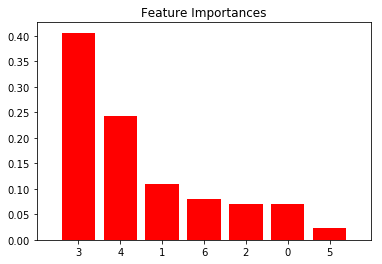

In [17]:
feature_importance = classifier.feature_importances_
index = np.argsort(feature_importance)[::-1]

plt.title("Feature Importances")
plt.bar(range(training_samples.shape[1]), feature_importance[index],
       color="r", align="center")
plt.xticks(range(training_samples.shape[1]), index)
plt.xlim([-1, training_samples.shape[1]])
plt.show()

# Classifying

In [10]:
#input data for process

#image size
r = 2500
c = 1000

#process size, rows per process
offset = 500

#y_start row
y_offset = 0
#y remains in the third part
y = r%offset
if(y == 0):
    y = offset

#num of iterations in the second part
k = (r-offset-y)/offset     #(rows-first_rows-third_rows)/offset

In [11]:
#first part
h_bands_data = []

for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    band_data = []
    
    h_bands_data.append(band.ReadAsArray(0, 0, c, offset))

h_bands_data = np.dstack(h_bands_data)
rows, cols, n_bands = h_bands_data.shape

print("Each process bands data shape (rows, cols, n_bands):")
print(h_bands_data.shape)

n_samples = rows*cols
flat_pixels = h_bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

print("Result classification shape (rows, cols):")
print(classification.shape)

y_offset += offset

Each process bands data shape (rows, cols, n_bands):
(500, 1000, 7)
Result classification shape (rows, cols):
(500, 1000)


In [ ]:
# #second part, one process
# h_bands_data = []

# for b in range(1, raster_dataset.RasterCount+1):
#     band = raster_dataset.GetRasterBand(b)
#     band_data = []
    
#     h_bands_data.append(band.ReadAsArray(0, 500, 1000, 500))

# h_bands_data = np.dstack(h_bands_data)
# rows, cols, n_bands = h_bands_data.shape

# n_samples = rows*cols
# flat_pixels = h_bands_data.reshape((n_samples, n_bands))
# result = classifier.predict(flat_pixels)
# classification2 = result.reshape((rows, cols))

# print("rows per process:")
# print(classification2.shape[0])

# for i in range(0, classification2.shape[0]):
#     classification = np.append(classification, [classification2[i]], 0)
    
# print("result classification shape, (rows, cols):")
# print(classification.shape)

In [350]:
#second part
for i in range(0, k):
    h_bands_data = []
    for b in range(1, raster_dataset.RasterCount+1):
        band = raster_dataset.GetRasterBand(b)
        band_data = []
    
        h_bands_data.append(band.ReadAsArray(0, y_offset, c, offset))

    h_bands_data = np.dstack(h_bands_data)
    rows, cols, n_bands = h_bands_data.shape

    n_samples = rows*cols
    flat_pixels = h_bands_data.reshape((n_samples, n_bands))
    result = classifier.predict(flat_pixels)
    classification2 = result.reshape((rows, cols))

    for i in range(0, classification2.shape[0]):
        classification = np.append(classification, [classification2[i]], 0)
    
    print("Result classification shape (rows, cols):")
    print(classification.shape)

    y_offset += offset
    
print
print("y_start = %d" % y_offset)
print("y_rows = %d" % y)

Result classification shape (rows, cols):
(1000, 1000)
Result classification shape (rows, cols):
(1500, 1000)
Result classification shape (rows, cols):
(2000, 1000)

y_start = 2000
y_rows = 500


In [351]:
#third part
h_bands_data = []

for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    band_data = []
    
    h_bands_data.append(band.ReadAsArray(0, y_offset, c, y))

h_bands_data = np.dstack(h_bands_data)
rows, cols, n_bands = h_bands_data.shape

n_samples = rows*cols
flat_pixels = h_bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification2 = result.reshape((rows, cols))

for i in range(0, classification2.shape[0]):
    classification = np.append(classification, [classification2[i]], 0)
    
print("result classification shape, (rows, cols):")
print(classification.shape)

result classification shape, (rows, cols):
(2500, 1000)


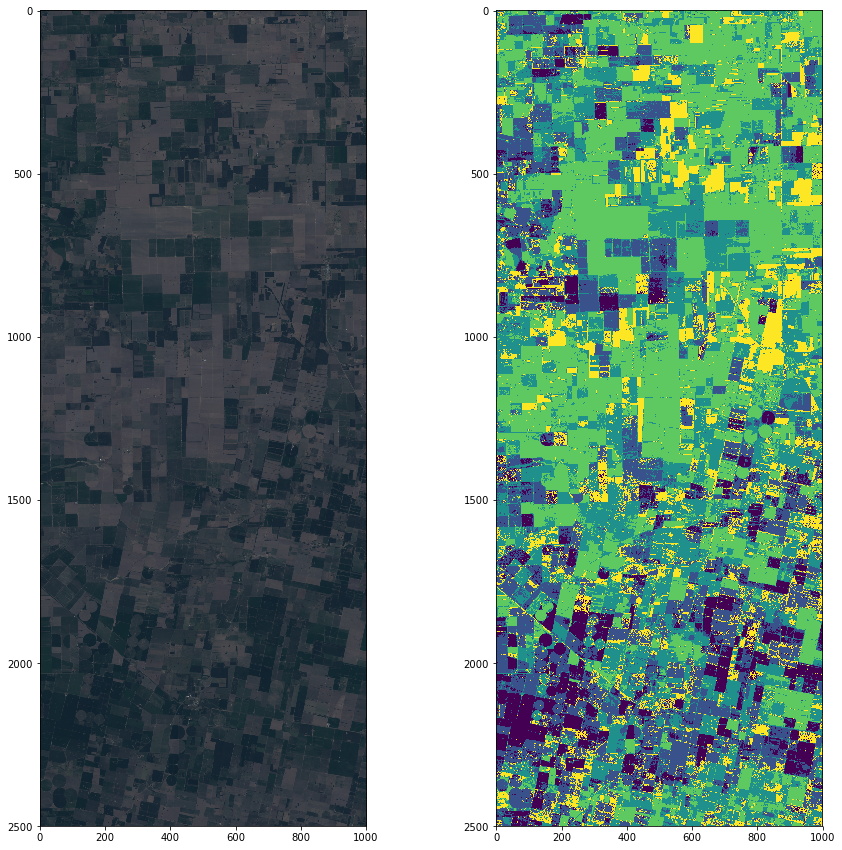

In [352]:
f = plt.figure(figsize=(15,15))
f.add_subplot(1, 2, 2)
r = bands_data[:,:,3]
g = bands_data[:,:,2]
b = bands_data[:,:,1]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 2, 1)
plt.imshow(rgb/255)
f.add_subplot(1, 2, 2)
plt.imshow(classification)

In [335]:
write_geotiff(output_fname, classification, geo_transform, proj)

# Assess the Results

### Pre-process our testing dataset.

In [336]:
shapefiles = [os.path.join(validation_data_path, "%s.shp" % c)
              for c in classes]
verification_pixels = vectors_to_raster(shapefiles, rows, cols,
                                        geo_transform, proj)
for_verification = np.nonzero(verification_pixels)
verification_labels = verification_pixels[for_verification]
predicted_labels = classification[for_verification]

### There we have the expected label for the verification pixels, and the computed labels. So we can analyze the results.

In [337]:
print("Confussion matrix:\n%s" %
      metrics.confusion_matrix(verification_labels, predicted_labels))

Confussion matrix:
[[ 41   0   0   0   0]
 [  0  27   0   0   0]
 [  0   0   9  18   0]
 [  0   0   0  43   0]
 [  0   0   0   0 114]]


### For precission and accuracy:

In [338]:
target_names = ['Class %s' % s for s in classes]
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,
                                    target_names=target_names))
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification report:
             precision    recall  f1-score   support

    Class A       1.00      1.00      1.00        41
    Class B       1.00      1.00      1.00        27
    Class C       1.00      0.33      0.50        27
    Class D       0.70      1.00      0.83        43
    Class E       1.00      1.00      1.00       114

avg / total       0.95      0.93      0.92       252

Classification accuracy: 0.928571


# OOB Errors for Random Forests

### Pick a relatively large number 500:

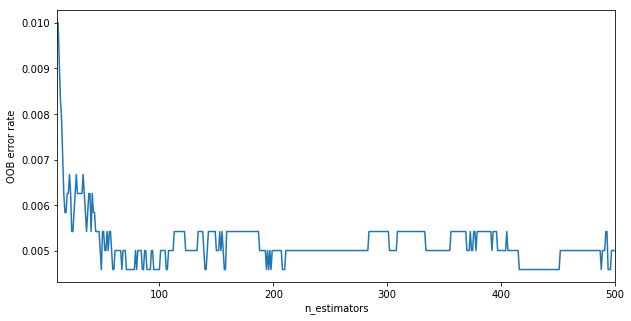

In [199]:
clf = RandomForestClassifier(warm_start=True, oob_score=True, max_features="sqrt")

#dict of (estimator, error_rate)
error_rate = {}

#explore max 500
min_estimators = 10
max_estimators = 500

for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i)
    clf.fit(training_samples, training_labels)
    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error
    
# Generate the "OOB error rate" vs. "n_estimators" plot.
er = sorted(error_rate.items())
x, y = zip(*er)
fig = plt.figure(figsize=(10,5))
plt.plot(x, y)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()
fig.savefig('temp.png', dpi = 300)

### According to the plot, narrow to 200:

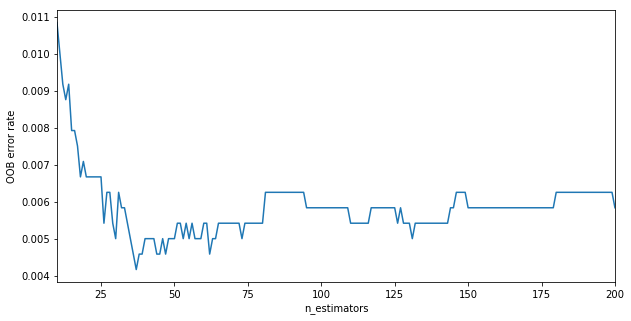

In [198]:
clf = RandomForestClassifier(warm_start=True, oob_score=True, max_features="sqrt")

#dict of (estimator, error_rate)
error_rate = {}

#explore max 200
min_estimators = 10
max_estimators = 200

for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i)
    clf.fit(training_samples, training_labels)
    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error
    
# Generate the "OOB error rate" vs. "n_estimators" plot.
er = sorted(error_rate.items())
x, y = zip(*er)
plt.figure(figsize=(10,5))
plt.plot(x, y)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()